<a href="https://colab.research.google.com/github/duttagoutam/CarDamageDetection/blob/main/04_damage_severity_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Step4:
##Determines the severity of the damage i.e minor, moderate, severe.
###Data- dataset of all images of cars(damaged ones)
#### minor, moderate, severe

In [2]:
import os
import urllib.request
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter 
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')
sns.set_palette("cubehelix")

In [3]:
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, History
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1

In [4]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [32]:
def train_categorical_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    print('train_data',train_data.shape)
    #train_labels = np.array([0]*(277) + [1]*(314) + [2]*(385))
    train_labels = np.array([0]*(277) + [1]*(314) + [2]*(385))
    train_labels = to_categorical(train_labels)
    print('train_labels',train_labels.shape)
    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    print('validation_data',validation_data.shape)
    #validation_labels = np.array([0]*(51) + [1]*(56) + [2]*(69))
    validation_labels = np.array([0]*(39) + [1]*(54) + [2]*(67))
    validation_labels = to_categorical(validation_labels)
    print('validation_labels',validation_labels.shape)
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [8]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")
    
    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))
    
    top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history

In [9]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, ', val_accuracy:', model_hist['val_accuracy'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

In [10]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout();
    
    print("Best Model:")
    print_best_model_results(hist)

In [11]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

## Image Dataset Details

In [21]:
#location = 'data4'
location = '/content/drive/My Drive/App/CarDamage/data3a'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
print('train_samples',train_samples)
#nb_train_samples = 976
nb_train_samples = 979
print('nb_train_samples',nb_train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
print('validation_samples',validation_samples)
#nb_validation_samples = 176
nb_validation_samples = 171
print('nb_validation_samples',nb_validation_samples)
img_width, img_height = 256,256
epochs = 50
batch_size = 16

train_samples [278, 315, 386]
nb_train_samples 979
validation_samples [48, 55, 68]
nb_validation_samples 171


In [22]:
save_bottleneck_features()

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [33]:
d4_model, d4_history = train_categorical_model()

train_data (976, 8, 8, 512)
train_labels (976, 3)
validation_data (160, 8, 8, 512)
validation_labels (160, 3)
Epoch 1/50
55/61 [==========================>...] - ETA: 0s - loss: 4.3260 - accuracy: 0.4534
Epoch 00001: val_accuracy improved from -inf to 0.61875, saving model to /content/drive/My Drive/App/CarDamage/data3a/top_model_weights.h5
61/61 [==============================] - 1s 10ms/step - loss: 3.9957 - accuracy: 0.4559 - val_loss: 0.9122 - val_accuracy: 0.6187
Epoch 2/50
55/61 [==========================>...] - ETA: 0s - loss: 1.0948 - accuracy: 0.5443
Epoch 00002: val_accuracy did not improve from 0.61875
61/61 [==============================] - 0s 6ms/step - loss: 1.0808 - accuracy: 0.5430 - val_loss: 0.9268 - val_accuracy: 0.5688
Epoch 3/50
55/61 [==========================>...] - ETA: 0s - loss: 1.0287 - accuracy: 0.5705
Epoch 00003: val_accuracy did not improve from 0.61875
61/61 [==============================] - 0s 7ms/step - loss: 1.0204 - accuracy: 0.5717 - val_loss: 0

Best Model:
epoch: 36 , val_accuracy: 0.625 , val_loss: 3.5323338508605957


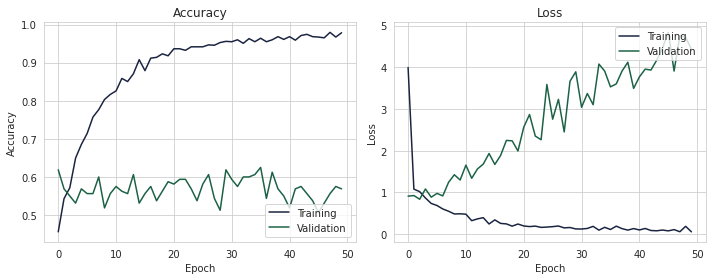

In [34]:
plot_metrics(d4_history)

In [35]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.6278 - accuracy: 0.7767
Epoch 00001: val_accuracy improved from -inf to 0.61250, saving model to /content/drive/My Drive/App/CarDamage/data3a/ft_model.h5
61/61 [==============================] - 17s 273ms/step - loss: 1.6278 - accuracy: 0.7767 - val_loss: 3.0119 - val_accuracy: 0.6125
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 1.3169 - accuracy: 0.7850
Epoch 00002: val_accuracy did not improve from 0.61250
61/61 [==============================] - 16s 258ms/step - loss: 1.3169 - accuracy: 0.7850 - val_loss: 3.1725 - val_accuracy: 0.6062
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 1.7447 - accuracy: 0.7809
Epoch 00003: val_accuracy improved from 0.61250 to 0.61875, saving model to /content/drive/My Dri

In [37]:
#ft_model = load_model('data4/ft_model.h5')
ft_model = load_model(location+'/ft_model.h5')

In [36]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [38]:
def pipe32(image_path, model):
    #urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img(image_path, target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'minor', 1:'moderate', 2:'severe'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating severity of damage....Result:",d[key])
    print("Severity assessment complete.")

imageName /content/drive/My Drive/App/CarDamage/data3a/Damage1.jpg


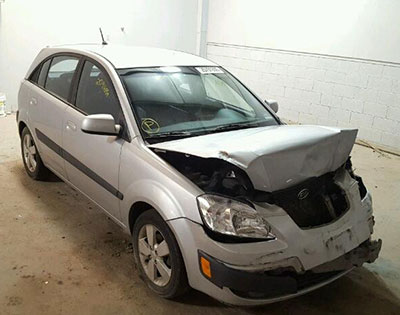

In [40]:
#Image('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg')
imageName='/content/drive/My Drive/App/CarDamage/data3a/Damage1.jpg'
print('imageName', imageName)
Image(imageName)
display(Image(filename=imageName))

In [42]:
#pipe32('https://www.copartdirect.com/content/2007-kia-rio-front-end-damage.jpg', ft_model)
imagePath='/content/drive/My Drive/App/CarDamage/data3a/Damage1.jpg'
print('imagePath:',imagePath)
pipe32(imagePath, ft_model)

imagePath: /content/drive/My Drive/App/CarDamage/data3a/Damage1.jpg
Validating severity of damage....Result: severe
Severity assessment complete.


In [44]:
#Image('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg')
imageName='/content/drive/My Drive/App/CarDamage/data3a/Damage2.jpg'
print('imageName', imageName)
Image(imageName)
display(Image(filename=imageName))

imageName /content/drive/My Drive/App/CarDamage/data3a/Damage2.jpg


KeyboardInterrupt: ignored

In [ ]:
pipe32('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg', ft_model)

Validating severity of damage....Result: moderate
Severity assessment complete.


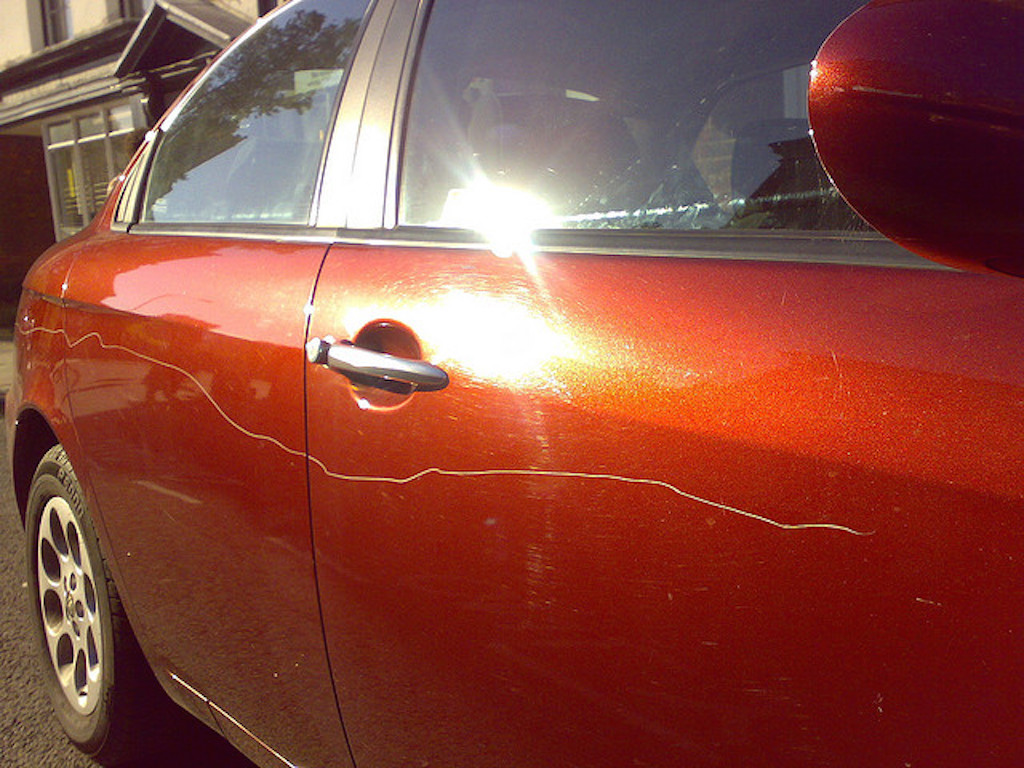

In [ ]:
Image('https://di-uploads-pod1.dealerinspire.com/depaulachevy/uploads/2015/07/Scratch-2.jpg')

In [ ]:
pipe32('https://di-uploads-pod1.dealerinspire.com/depaulachevy/uploads/2015/07/Scratch-2.jpg', ft_model)

Validating severity of damage....Result: minor
Severity assessment complete.
